<a href="https://colab.research.google.com/github/JALB-epsilon/CAAM554_Codes/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The following notebook contains all the problem from the HW8 CAAM 554.
The order of the problem is not like the one presented in the HW.

##Setting Libraries
We use Jax since contains all the main setting of numpy with the advantage of using software accelerators to improve the performance of all the linear algebra operators.


In [160]:
import jax 
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, hessian, jit, jacfwd, jacrev
from jax import random, device_put
import matplotlib.pyplot as plt
key = random.PRNGKey(10)

If you want to make use of the GPU or TPU in google colab. 

Go to Runtime $\Rightarrow$ Change runtime type $\Rightarrow$ Hardware accelerator. 

In [2]:
#The device used is
jax.devices()

[GpuDevice(id=0, process_index=0)]

#Problem 2 iii

In [3]:
#Rosenbrock's function
def Rosenbrock(x):
    if len(x)%2==1: print(f"The input has dimension {n}, it is not even and f is undefined")
    else:
      return jnp.sum(100.0*(x[::2]**2.0-x[1::2])**2.0 + (x[::2]-1)**2.0)
#Compiling the function into the device to improve performance
jit_Rosenbrock= jit(Rosenbrock)
#Obtaining the gradient and then compiling (making use of the built-in library)
jit_grad_R = jit(grad(jit_Rosenbrock)) 
#Calculating the hessian
jit_Hess_R = jit(hessian(jit_Rosenbrock))

In [4]:
#Sanity check
x =jnp.array([1.,2.,1.,2.])


In [5]:
#Result from the Rosenbrock
jit_Rosenbrock(x)

DeviceArray(200., dtype=float64)

In [6]:
#Gradient of the Rosenbrock's funtion
jit_grad_R(x)

DeviceArray([-400.,  200., -400.,  200.], dtype=float64)

In [7]:
#Hessian of the Rosenbrock's function
jit_Hess_R(x)

DeviceArray([[ 402., -400.,    0.,    0.],
             [-400.,  200.,    0.,    0.],
             [   0.,    0.,  402., -400.],
             [   0.,    0., -400.,  200.]], dtype=float64)

In [8]:
jax.hessian(jit_Rosenbrock)(x)

DeviceArray([[ 402., -400.,    0.,    0.],
             [-400.,  200.,    0.,    0.],
             [   0.,    0.,  402., -400.],
             [   0.,    0., -400.,  200.]], dtype=float64)

#**Gradient Descent**

###In the following we implement the GD method. In the following code we add some extra feautures like control over tolerance, choosing the gradient of estimated gradient

In [9]:
dim = 2400
#x = device_put(2.*jnp.ones(dim))
x = device_put(random.uniform(key, (dim,)))

In [10]:
def grad_descent(x =x,
                 jit_grad = jit_grad_R,
                 alpha =0.001, 
                 tol = 1e-7,
                 maxIt =5000, 
                 PrintVar =100,
                 PrintX = None,
                 save_files = None,
                 x_sol = jnp.empty_like(x)
                 ):
  n = len(x)
  if n < 20: 
    print(f"x_0 = {x}")
  if save_files: 
    val_x = []
    val_grad= []
    iter = []
  for i in range(maxIt): 
      grad = jit_grad(x)
      grad_norm =jnp.linalg.norm(grad,ord=2)
      x += alpha*(-grad)
      if i%PrintVar ==0: 
          print(f"iteration: {i}, grad_norm: {grad_norm}" )
          if PrintX: 
              print(f"x: {x}")
          if save_files:
            error_x = jnp.linalg.norm(x-x_sol,ord=2)
            val_x.append(error_x)
            val_grad.append(grad_norm)
            iter.append(i)
      if grad_norm< tol:
          print("****************************************")
          print(f"stop because grad_norm= {grad_norm} < {tol}")
          break   
      if jnp.isnan(grad_norm):
          print("****************************************")
          print(f"stop because grad_norm= {grad_norm}, GD method diverges")
          break           
  print("****************************************")
  if n< 20: 
    print(f"iteration: {i}, grad_norm: {grad_norm}, \nx={x}")
  else: 
    print(f"iteration: {i}, grad_norm: {grad_norm}")
  if save_files:
    return val_x, val_grad, iter,x
  else:
    return x
    

In [90]:
dim = 2400
#x = device_put(2.*jnp.ones(dim))
x = device_put(random.uniform(key, (dim,)))
x_sol = grad_descent(x,
                     alpha =0.0015, 
                     maxIt =2000, 
                     PrintVar =100)

iteration: 0, grad_norm: 4587.812150465511
iteration: 100, grad_norm: 21.29910916989103
iteration: 200, grad_norm: 16.734779558886064
iteration: 300, grad_norm: 13.818427049074078
iteration: 400, grad_norm: 11.758547866093778
iteration: 500, grad_norm: 10.204076813665203
iteration: 600, grad_norm: 8.977973584861177
iteration: 700, grad_norm: 7.98027775956703
iteration: 800, grad_norm: 7.14956116335958
iteration: 900, grad_norm: 6.445588133490379
iteration: 1000, grad_norm: 5.840673589163305
iteration: 1100, grad_norm: 5.315010418686568
iteration: 1200, grad_norm: 4.853972932258279
iteration: 1300, grad_norm: 4.446476085718535
iteration: 1400, grad_norm: 4.083932487621429
iteration: 1500, grad_norm: 3.759564639779582
iteration: 1600, grad_norm: 3.467937069765703
iteration: 1700, grad_norm: 3.204629409272678
iteration: 1800, grad_norm: 2.9660025791959854
iteration: 1900, grad_norm: 2.7490281174859956
****************************************
iteration: 1999, grad_norm: 2.5530527791906428


In [91]:
x_sol

DeviceArray([0.97012298, 0.94101688, 0.99495185, ..., 0.88222466,
             0.93376464, 0.87164062], dtype=float64)

#### After increasing the number of iterations, since the function has been compiled in the device used (CPU, TPU or GPU). There is no problem to increasing the number of iterations to improve the accuracy.
## **Results Gradient Descent**
Gradient Descent is converging towards the vector of 1s. 
$\mathbb{1} = [1,1, \ldots, 1]^\top.$




#**Newton Method**

In [92]:
def newton_method(x,
                 jit_f= Rosenbrock,
                 jit_grad = jit_grad_R,
                 jit_hess = jit_Hess_R,
                 alpha =1, 
                 tol = 1e-7,
                 maxIt =100, 
                 PrintVar =10,
                 PrintX = None,
                 save_files = None,
                 adaptative_lr = False,
                 x_sol = jnp.empty_like(x)
                 ):
  n =len(x)
  if n < 20: 
    print(f"x_0 = {x}")
  if save_files: 
    val_x = []
    val_grad= []
    iter = []
  for i in range(maxIt):
    grad = jit_grad(x)
    hess = jit_hess(x)
    grad_norm =jnp.linalg.norm(grad,ord=2)
    s = jnp.linalg.solve(hess, -grad)
    while adaptative_lr: #adding the adaptative LR if needed
      if jit_f(x+alpha*s)>(jit_f(x)+1e-4*alpha*jnp.dot(grad,s)):
        alpha*=1/2
      else: break
    x+= alpha*s
    if i%PrintVar ==0: 
      if adaptative_lr:
        print(f"iteration: {i}, grad_norm: {grad_norm} alpha {alpha}" )
      else: 
        print(f"iteration: {i}, grad_norm: {grad_norm}" )
      if PrintX:
        print(f"x: {x}")
      if save_files:
        error_x = jnp.linalg.norm(x-x_sol,ord=2)
        val_x.append(error_x)
        val_grad.append(grad_norm)
        iter.append(i)
    if grad_norm< tol:
        print("****************************************")
        print(f"stop because grad_norm= {grad_norm}< {tol}")
        break            
    if jnp.isnan(grad_norm):
        print("****************************************")
        print(f"stop because grad_norm= {grad_norm}, Newton method diverges")
        break    
  print("****************************************")
  if n< 20: 
    print(f"iteration: {i}, grad_norm: {grad_norm}, \nx={x}")
  else: 
    print(f"iteration: {i}, grad_norm: {grad_norm}")
  if save_files:
    return val_x, val_grad, iter, x
  else:
    return x

In [93]:
dim = 2400
#x = device_put(2.*jnp.ones(dim))
x = device_put(random.uniform(key, (dim,)))
x_sol = newton_method(x, 
                      alpha =1,
                      tol = 1e-24, 
                      maxIt =100,
                      PrintVar =1)

iteration: 0, grad_norm: 4587.812150465511
iteration: 1, grad_norm: 82590.33826303239
iteration: 2, grad_norm: 6165.865485727857
iteration: 3, grad_norm: 16349.095525123405
iteration: 4, grad_norm: 424.5938344900259
iteration: 5, grad_norm: 296.3311814315704
iteration: 6, grad_norm: 105.15545910654716
iteration: 7, grad_norm: 73.3450775439057
iteration: 8, grad_norm: 9.557025967481271
iteration: 9, grad_norm: 0.1265399464818347
iteration: 10, grad_norm: 0.03280550979306885
iteration: 11, grad_norm: 5.592865507674127e-07
iteration: 12, grad_norm: 7.996787647669593e-12
iteration: 13, grad_norm: 0.0
****************************************
stop because grad_norm= 0.0< 1e-24
****************************************
iteration: 13, grad_norm: 0.0


In [94]:
x_sol

DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float64)

#### After increasing the number of iterations, since the function has been compiled in the device used (CPU, TPU or GPU). There is no problem to increasing the number of iterations to improve the accuracy.
## **Results Newton Method**
Newton Method is converes towards the vector of 1s. 
$\mathbb{1} = [1,1, \ldots, 1]^\top.$

##Plotting



In [95]:
dim = 2400
x_sol = device_put(jnp.ones(dim))

xinit = 2*x_sol
val_x_gd, val_grad_gd, iter_gd, x_sol_gd = grad_descent(xinit, 
                                              alpha =1e-3, 
                                              maxIt =100, 
                                              tol = 1e-7,
                                              save_files= 1, 
                                              PrintVar =10,
                                              x_sol= x_sol)

iteration: 0, grad_norm: 57198.64334055485
iteration: 10, grad_norm: 36.55673682737456
iteration: 20, grad_norm: 6.9576131372224195
iteration: 30, grad_norm: 6.942454716042602
iteration: 40, grad_norm: 6.927405107138504
iteration: 50, grad_norm: 6.912365505324413
iteration: 60, grad_norm: 6.897335982061411
iteration: 70, grad_norm: 6.882316608714272
iteration: 80, grad_norm: 6.867307456569616
iteration: 90, grad_norm: 6.852308596834214
****************************************
iteration: 99, grad_norm: 6.8388184818689


In [96]:
xinit = 2*x_sol

val_x_newton, val_grad_newton, iter_newton, x_sol_newton = newton_method(xinit, 
                                                                    alpha =1, 
                                                                    maxIt =100, 
                                                                    tol = 1e-24,
                                                                    save_files= 1, 
                                                                    PrintVar =1, 
                                                                    x_sol = x_sol)

iteration: 0, grad_norm: 57198.64334055485
iteration: 1, grad_norm: 69.28139995367826
iteration: 2, grad_norm: 15391.811176662282
iteration: 3, grad_norm: 0.0854197109002573
iteration: 4, grad_norm: 0.02354914480863438
iteration: 5, grad_norm: 1.9998811938389065e-13
iteration: 6, grad_norm: 0.0
****************************************
stop because grad_norm= 0.0< 1e-24
****************************************
iteration: 6, grad_norm: 0.0


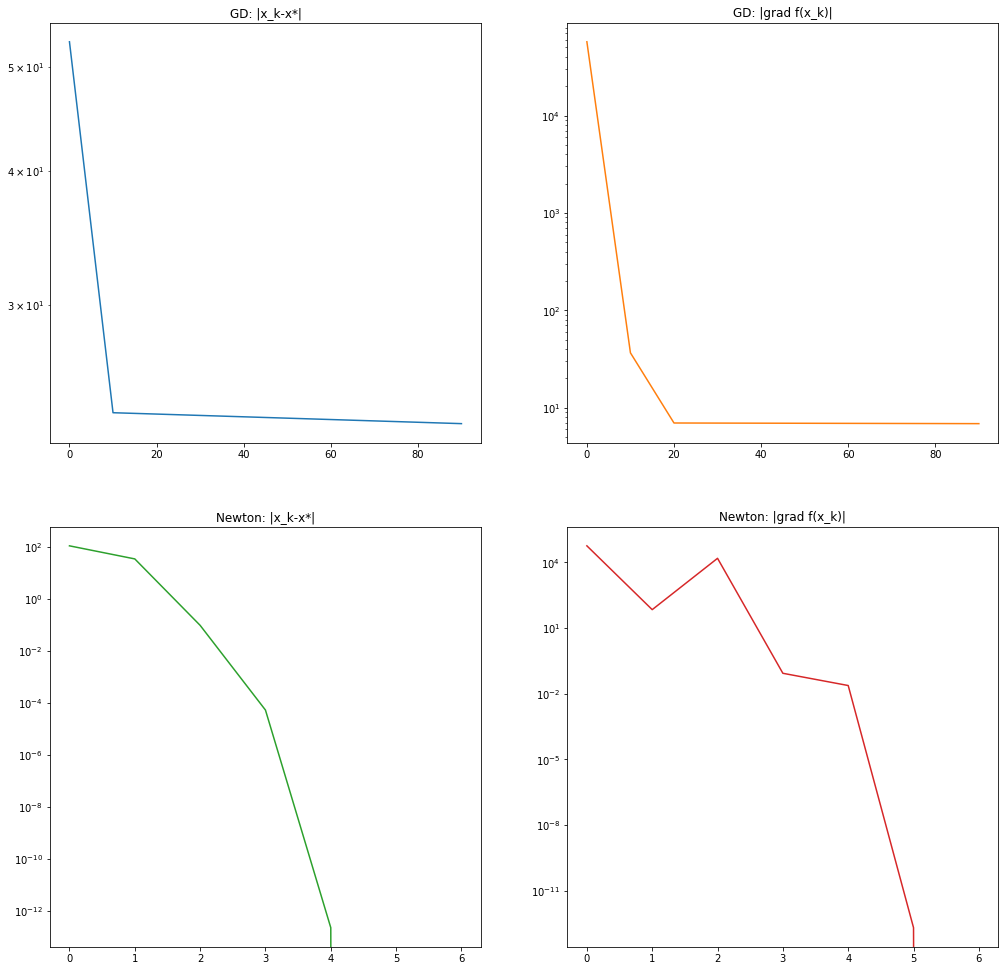

In [97]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(iter_gd, val_x_gd)
axs[0, 0].set_title('GD: |x_k-x*|')
axs[0, 0].set_yscale('log')
axs[0, 1].plot(iter_gd, val_grad_gd, 'tab:orange')
axs[0, 1].set_title('GD: |grad f(x_k)|')
axs[0, 1].set_yscale('log')

axs[1, 0].plot(iter_newton, val_x_newton, 'tab:green')
axs[1, 0].set_title('Newton: |x_k-x*|')
axs[1, 0].set_yscale('log')
axs[1, 1].plot(iter_newton, val_grad_newton, 'tab:red')
axs[1, 1].set_title('Newton: |grad f(x_k)|')
axs[1, 1].set_yscale('log')


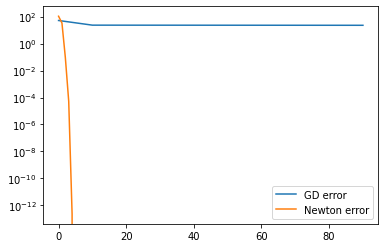

In [98]:
plt.plot(iter_gd, val_x_gd)
plt.plot(iter_newton, val_x_newton)
plt.yscale('log')
plt.legend(["GD error", "Newton error"]);

##Adding the change of variables when $n=10$ as the changes in HW April 12 indicated.

In [150]:
dim = 10
xinit= device_put(2*jnp.ones(dim))
x_sol = device_put(jnp.ones(dim))

In [111]:
def grad_descent_scaling(x, S,
                        jit_f= Rosenbrock,
                        jit_grad = jit_grad_R,
                        alpha =0.001, 
                        tol = 1e-7,
                        maxIt =2000, 
                        PrintVar =100,
                        PrintX = None,
                        save_files = None,
                        x_sol = jnp.empty_like(x)
                        ):
  n = len(x)
  SS = device_put(jnp.matmul(S.T, S))
  if n < 20: 
    print(f"x_0 = {x}")
  if save_files: 
    val_x = []
    val_grad= []
    iter = []
  for i in range(maxIt): 
      grad = jit_grad(x)
      grad_norm =jnp.linalg.norm(grad,ord=2)
      s = jnp.linalg.solve(SS, -grad)
      while True:
        if jit_f(x+alpha*s)>(jit_f(x)+1e-4*alpha*jnp.dot(grad,s)):
          alpha*=1/2
        else: break
      x += alpha*s
      if i%PrintVar ==0: 
          print(f"iteration: {i}, grad_norm: {grad_norm} alpha: {alpha}" )
          if PrintX: 
              print(f"x: {x}")
          if save_files:
            error_x = jnp.linalg.norm(x-x_sol,ord=2)
            val_x.append(error_x)
            val_grad.append(grad_norm)
            iter.append(i)
      if grad_norm< tol:
          print("****************************************")
          print(f"stop because grad_norm= {grad_norm} < {tol}")
          break   
      if jnp.isnan(grad_norm):
          print("****************************************")
          print(f"stop because grad_norm= {grad_norm}, GD method diverges")
          break           
  print("****************************************")
  if n< 20: 
    print(f"iteration: {i}, grad_norm: {grad_norm}, \nx={x}")
  else: 
    print(f"iteration: {i}, grad_norm: {grad_norm}")
  if save_files:
    return val_x, val_grad, iter,x
  else:
    return x

In [151]:
alpha = 1
maxIt=3000
eps=1e-7
save_files =1
PrintVar= 100

In [153]:
#Without scaling
val_x_gd, val_grad_gd, iter_gd, x_sol_gd  = grad_descent(xinit,
                                                        alpha = 1e-3, 
                                                        maxIt =maxIt,
                                                        tol = eps,
                                                        save_files =save_files, 
                                                        PrintVar =PrintVar,
                                                        x_sol = x_sol)

x_0 = [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
iteration: 0, grad_norm: 3692.1565513937785
iteration: 100, grad_norm: 0.44134711470735966
iteration: 200, grad_norm: 0.43170988103335284
iteration: 300, grad_norm: 0.4221445502831688
iteration: 400, grad_norm: 0.41265560836834964
iteration: 500, grad_norm: 0.403247463030714
iteration: 600, grad_norm: 0.39392443249910947
iteration: 700, grad_norm: 0.3846907343854064
iteration: 800, grad_norm: 0.37555047488590915
iteration: 900, grad_norm: 0.36650763835277433
iteration: 1000, grad_norm: 0.3575660772977497
iteration: 1100, grad_norm: 0.34872950288760673
iteration: 1200, grad_norm: 0.3400014759870552
iteration: 1300, grad_norm: 0.33138539880078816
iteration: 1400, grad_norm: 0.3228845071615755
iteration: 1500, grad_norm: 0.31450186350616505
iteration: 1600, grad_norm: 0.3062403505751463
iteration: 1700, grad_norm: 0.2981026658670398
iteration: 1800, grad_norm: 0.2900913168706671
iteration: 1900, grad_norm: 0.2822086170935389
iteration: 2000, grad_norm

In [155]:
H = (random.uniform(key, (dim,dim)))
Q, R = jnp.linalg.qr(H)
#with sclaing S^TS = Id
val_x_gd1, val_grad_gd1, iter_gd1, x_sol_gd1  = grad_descent_scaling(xinit,
                                                                    S=device_put(Q),
                                                                    alpha =alpha, 
                                                                    maxIt =maxIt,
                                                                    tol = eps,
                                                                    save_files =save_files, 
                                                                    PrintVar =PrintVar,
                                                                    x_sol = x_sol)

x_0 = [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
iteration: 0, grad_norm: 3692.1565513937785 alpha: 0.001953125
iteration: 100, grad_norm: 3.488473203910373 alpha: 0.00048828125
iteration: 200, grad_norm: 3.5040728150027527 alpha: 0.00048828125
iteration: 300, grad_norm: 3.5203345921289917 alpha: 0.00048828125
iteration: 400, grad_norm: 3.5373075738618023 alpha: 0.00048828125
iteration: 500, grad_norm: 3.5550460298133326 alpha: 0.00048828125
iteration: 600, grad_norm: 3.5736101931944253 alpha: 0.00048828125
iteration: 700, grad_norm: 3.593067120644093 alpha: 0.00048828125
iteration: 800, grad_norm: 3.6134917056628737 alpha: 0.00048828125
iteration: 900, grad_norm: 3.6349678782486707 alpha: 0.00048828125
iteration: 1000, grad_norm: 3.6575900312474814 alpha: 0.00048828125
iteration: 1100, grad_norm: 3.681464723946754 alpha: 0.00048828125
iteration: 1200, grad_norm: 3.706712726120205 alpha: 0.00048828125
iteration: 1300, grad_norm: 3.733471481764219 alpha: 0.00048828125
iteration: 1400, grad_norm: 3

In [157]:
hess_sol = jit_Hess_R(x_sol)
Q= jax.scipy.linalg.cholesky(hess_sol)
#with sclaing S^TS = hess
val_x_gd2, val_grad_gd2, iter_gd2, x_sol_gd2  = grad_descent_scaling(xinit,
                                                                    S=device_put(Q),
                                                                    alpha =1,
                                                                    maxIt =maxIt,
                                                                    tol = eps,
                                                                    save_files =save_files, 
                                                                    PrintVar =PrintVar,
                                                                     x_sol = x_sol)

x_0 = [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
iteration: 0, grad_norm: 3692.1565513937785 alpha: 0.00390625
iteration: 100, grad_norm: 672.6102724988563 alpha: 0.00390625
iteration: 200, grad_norm: 454.7628798382963 alpha: 0.00390625
iteration: 300, grad_norm: 307.4726707793065 alpha: 0.00390625
iteration: 400, grad_norm: 207.88733528509604 alpha: 0.00390625
iteration: 500, grad_norm: 140.55605027400264 alpha: 0.00390625
iteration: 600, grad_norm: 95.03225986101859 alpha: 0.00390625
iteration: 700, grad_norm: 64.25287560860326 alpha: 0.00390625
iteration: 800, grad_norm: 43.44242712961233 alpha: 0.00390625
iteration: 900, grad_norm: 29.372140266652362 alpha: 0.00390625
iteration: 1000, grad_norm: 19.858987649790883 alpha: 0.00390625
iteration: 1100, grad_norm: 13.426988530430895 alpha: 0.00390625
iteration: 1200, grad_norm: 9.078208022261558 alpha: 0.00390625
iteration: 1300, grad_norm: 6.13792591754081 alpha: 0.00390625
iteration: 1400, grad_norm: 4.149952774471832 alpha: 0.00390625
iteration

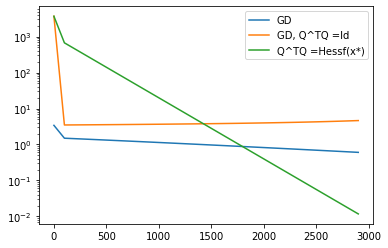

In [158]:

plt.plot(iter_gd, val_x_gd)
plt.plot(iter_gd1, val_grad_gd1)
plt.plot(iter_gd2, val_grad_gd2)
plt.yscale('log')
plt.legend(["GD", "GD, Q^TQ =Id",  "Q^TQ =Hessf(x*)"]);

Newton with adaptative step

In [73]:
xinit = 2*x_sol

val_x_newtonadap, val_grad_newtonadap, iter_newtonadap, x_sol_newtonadap = newton_method(xinit, 
                                                                    alpha =1, 
                                                                    maxIt =250, 
                                                                    tol = 1e-14,
                                                                    save_files= 1, 
                                                                    PrintVar =50, 
                                                                    x_sol = x_sol,
                                                                    adaptative_lr = True)

x_0 = [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
iteration: 0, grad_norm: 3692.1565513937785 alpha 1
iteration: 50, grad_norm: 0.0035487746957158436 alpha 0.25
iteration: 100, grad_norm: 2.0117481690036805e-09 alpha 0.25
iteration: 150, grad_norm: 1.0923150274288002e-14 alpha 4.547473508864641e-13
iteration: 200, grad_norm: 1.0923150274288002e-14 alpha 4.547473508864641e-13
****************************************
iteration: 249, grad_norm: 1.0923150274288002e-14, 
x=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


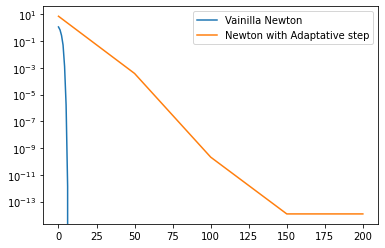

In [74]:
plt.plot(iter_newton, val_x_newton)
plt.plot(iter_newtonadap, val_x_newtonadap)
plt.yscale('log')
plt.legend(["Vainilla Newton", "Newton with Adaptative step"]);

#Problem 1 iii

In [30]:
@jit
#Defining the exponential to work of vectors
def f(x):
  return jnp.exp(x)
jacobian_f = jacrev(f)  #using AD
hess_f = hessian(f)     #using AD
#One Side Finite Difference
def first_oneSide_FD(f, x, eps = 1e-3):
   return jnp.array([(f(x + eps * v) - f(x)) / (eps)
                   for v in jnp.eye(len(x))])
#First Centered Finite Difference
def first_centered_FD(f, x, eps = 1e-3):
   return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])
#Second Centered Finite Difference  
def second_centered_FD(f, x, eps = 1e-3):
   Id =jnp.eye(len(x))
   return jnp.array([((f(x + eps * v)- 2*f(x) + f(x - eps * v)) / (eps**2))*Id
                   for v in Id])

In [31]:
x = jnp.array([3., 1., 4.])

In [32]:
jacobian_f(x)

DeviceArray([[20.08553692,  0.        ,  0.        ],
             [ 0.        ,  2.71828183,  0.        ],
             [ 0.        ,  0.        , 54.59815003]], dtype=float64)

In [33]:
first_centered_FD(f,x)

DeviceArray([[20.08554027,  0.        ,  0.        ],
             [ 0.        ,  2.71828228,  0.        ],
             [ 0.        ,  0.        , 54.59815913]], dtype=float64)

In [34]:
#Asked in the exercise
x = jnp.array([1.], dtype=jnp.float64)
deriv = jacobian_f(x)
hess = hess_f(x)


In [35]:
#Set up the error
def error(fapprox, f, exact):
  vec = jnp.array([fapprox(f, x, eps = 10**(-(i+1))) for  i in range(20)])
  return jnp.abs(vec-exact)


In [36]:
eps_vec =[10**(-(i+1)) for  i in range(20)]
error_1st_sided_DF = error(fapprox = first_oneSide_FD, f=f, exact = deriv).flatten()
error_1st_central_DF = error(fapprox = first_centered_FD, f=f, exact = deriv).flatten()
error_2nd_cental_DF = error(fapprox = second_centered_FD, f=f, exact = hess).flatten()

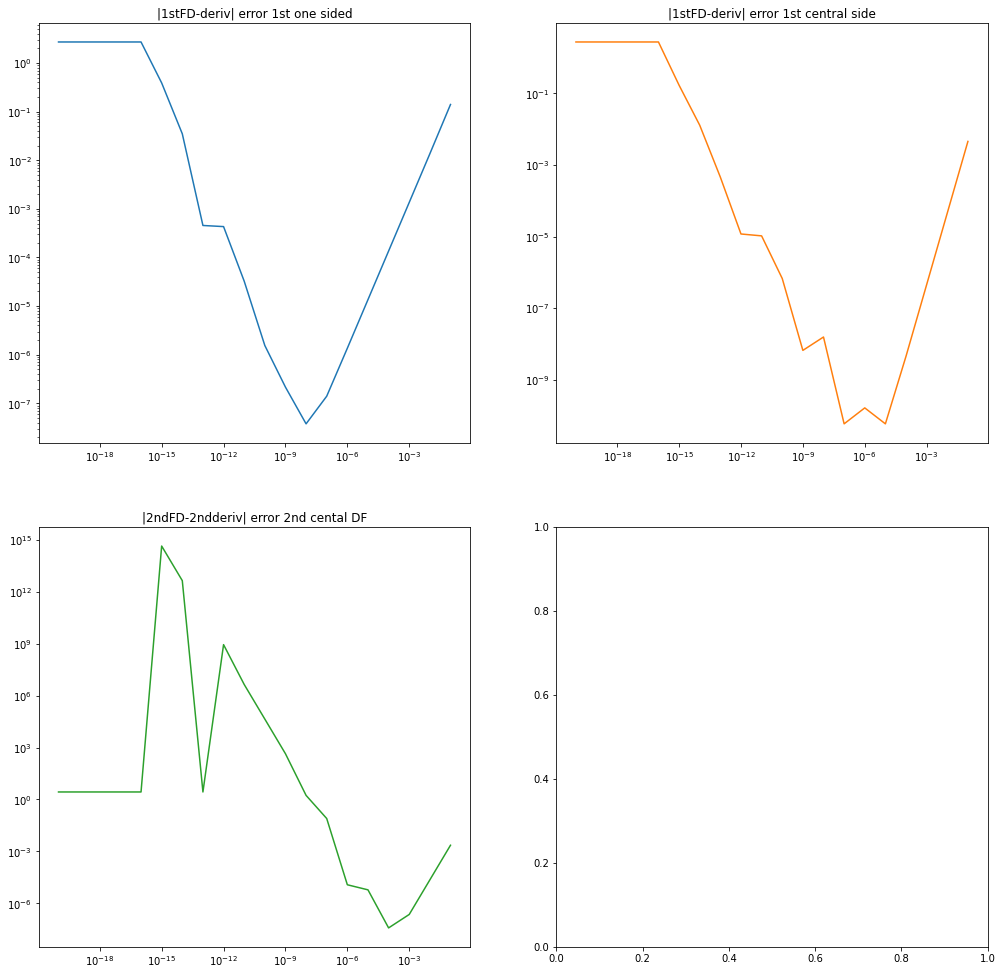

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(eps_vec, error_1st_sided_DF)
axs[0, 0].set_title('|1stFD-deriv| error 1st one sided')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xscale('log')
axs[0, 1].plot(eps_vec, error_1st_central_DF, 'tab:orange')
axs[0, 1].set_title('|1stFD-deriv| error 1st central side')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xscale('log')
axs[1, 0].plot(eps_vec, error_2nd_cental_DF, 'tab:green')
axs[1, 0].set_title('|2ndFD-2ndderiv| error 2nd cental DF')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')


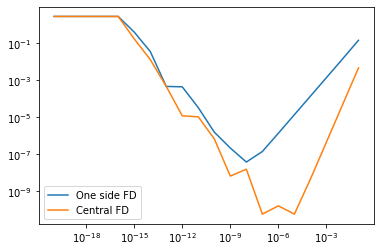

In [55]:
plt.plot(eps_vec, error_1st_sided_DF)
plt.plot(eps_vec, error_1st_central_DF)
plt.yscale('log')
plt.xscale('log')
plt.legend(["One side FD", "Central FD"]);

#Problem 3 i and ii


In [39]:
#Defining the function of the problem
def func_probl_3(x):
  return (x[0]-2)**4+((x[0]-2)**2)*x[1]**2+(x[1]+1)**2
#Compiling to improve performance
jit_func_3 = jit(func_probl_3)
#gradient
jit_grad_f_3 = jit(grad(jit_func_3))
#hessian
jit_hess_f_3 = jit(hessian(jit_func_3))


In [40]:
#starting value
x = device_put(jnp.array([1.,1.]))
x_sol_3 = device_put(jnp.array([2.,-1.]))

In [41]:
#minimizing func_probl_3 by GD at [1.,1.]
val_x_gd, val_grad_gd, iter_gd, x_sol_gd = grad_descent(x,
                                                jit_grad = jit_grad_f_3,
                                                alpha =0.001, 
                                                tol = 1e-7,
                                                maxIt =100, 
                                                PrintVar =5,
                                                x_sol = x_sol_3,
                                                save_files= 1
                                                )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.48528137423857
iteration: 5, grad_norm: 7.966363376280803
iteration: 10, grad_norm: 7.512353981063662
iteration: 15, grad_norm: 7.112323071830988
iteration: 20, grad_norm: 6.757565031350937
iteration: 25, grad_norm: 6.441071894091436
iteration: 30, grad_norm: 6.157147985838134
iteration: 35, grad_norm: 5.901123859937425
iteration: 40, grad_norm: 5.669141075814781
iteration: 45, grad_norm: 5.45798828293698
iteration: 50, grad_norm: 5.26497497491238
iteration: 55, grad_norm: 5.0878332532913815
iteration: 60, grad_norm: 4.92464066143828
iteration: 65, grad_norm: 4.773759039211066
iteration: 70, grad_norm: 4.633785680819987
iteration: 75, grad_norm: 4.503514028377967
iteration: 80, grad_norm: 4.381901819736057
iteration: 85, grad_norm: 4.268045110153166
iteration: 90, grad_norm: 4.1611569569659075
iteration: 95, grad_norm: 4.060549831813764
****************************************
iteration: 99, grad_norm: 3.984178926812638, 
x=[1.31840247 0.5449302

In [42]:
#minimizing func_probl_3 by Newton at [1.,1.]
val_x_newton, val_grad_newton, iter_newton, x_sol_newton = newton_method(x,
                                                                  jit_grad = jit_grad_f_3,
                                                                  jit_hess = jit_hess_f_3,
                                                                  alpha =1, 
                                                                  tol = 1e-15,
                                                                  maxIt =500, 
                                                                  PrintVar =1 ,
                                                                  x_sol = x_sol_3,
                                                                  save_files= 1
                                                                  )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.48528137423857
iteration: 1, grad_norm: 4.5
iteration: 2, grad_norm: 1.4941565678058275
iteration: 3, grad_norm: 0.5233879412189747
iteration: 4, grad_norm: 0.1014010888447795
iteration: 5, grad_norm: 0.002555612918113977
iteration: 6, grad_norm: 3.319064059945663e-06
iteration: 7, grad_norm: 2.808149089867246e-12
iteration: 8, grad_norm: 0.0
****************************************
stop because grad_norm= 0.0< 1e-15
****************************************
iteration: 8, grad_norm: 0.0, 
x=[ 2. -1.]


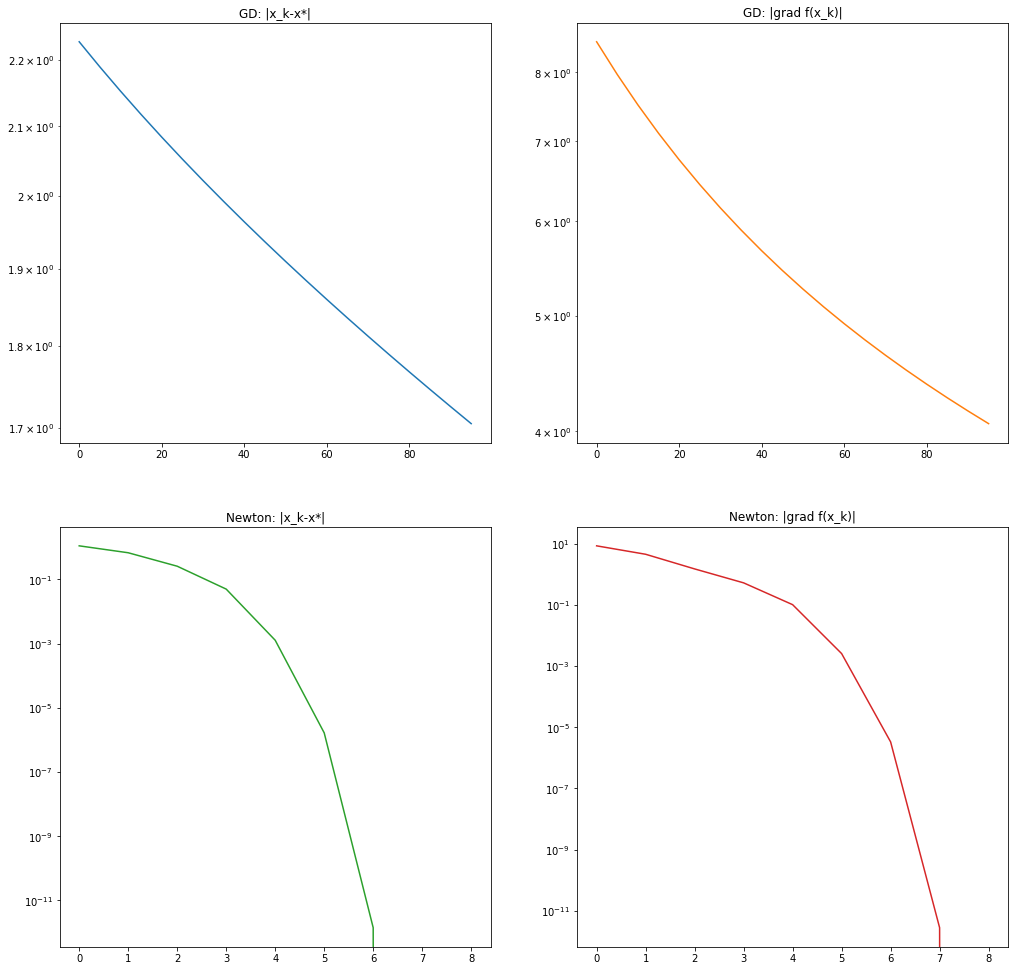

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(iter_gd, val_x_gd)
axs[0, 0].set_title('GD: |x_k-x*|')
axs[0, 0].set_yscale('log')
axs[0, 1].plot(iter_gd, val_grad_gd, 'tab:orange')
axs[0, 1].set_title('GD: |grad f(x_k)|')
axs[0, 1].set_yscale('log')

axs[1, 0].plot(iter_newton, val_x_newton, 'tab:green')
axs[1, 0].set_title('Newton: |x_k-x*|')
axs[1, 0].set_yscale('log')
axs[1, 1].plot(iter_newton, val_grad_newton, 'tab:red')
axs[1, 1].set_title('Newton: |grad f(x_k)|')
axs[1, 1].set_yscale('log')

###Problem 3 ii Using FD


In [44]:
#defining the hessian for the case of two dimension
def hess_prob_3(f, x, eps1 = 1e-3, eps2= 1e-3):
   Id =jnp.eye(len(x)); hess = []
   for v in Id:
     for w in Id:
       approx = (f(x+eps1*v+eps2*w)-f(x+eps1*v)-f(x+eps2*w)+f(x))/(eps1*eps2)
       hess.append(approx)
   return jnp.reshape(jnp.array(hess), (2,2))

#setting the hessian ready to the newton method 
def hess_func_probl_3_approx(x, f= func_probl_3, eps1 = 1e-1, eps2= 1e-1):
  return hess_prob_3(f=func_probl_3, x=x, eps1 = eps1, eps2 = eps2)


In [45]:
#GD using the the grad approx.
#reusing our previous algorithm for approx. the gradient
def approx_1(x, f= func_probl_3, eps = 1e-1):
  return first_oneSide_FD(f= func_probl_3, x= x, eps = eps)
def approx_2(x, f= func_probl_3, eps = 1e-3):
  return first_oneSide_FD(f= func_probl_3, x= x, eps = eps)
#hessian
def hess_aprox1(x, f= func_probl_3, eps1 = 1e-1, eps2= 1e-1):
  return hess_prob_3(f=func_probl_3, x=x, eps1 = eps1, eps2 = eps2)
#hessian 2
def hess_aprox2(x, f= func_probl_3, eps1 = 1e-3, eps2= 1e-3):
  return hess_prob_3(f=func_probl_3, x=x, eps1 = eps1, eps2 = eps2)

### Using GD

In [46]:
#approx1 GD
val_x_gd1, val_grad_gd1, iter_gd1, x_sol_gd1 = grad_descent(x,
                                                jit_grad = approx_1,
                                                alpha =0.001, 
                                                tol = 1e-7,
                                                maxIt =100, 
                                                PrintVar =5,
                                                x_sol = x_sol_3,
                                                save_files= 1
                                                )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.18198759471072
iteration: 5, grad_norm: 7.729043986871324
iteration: 10, grad_norm: 7.329128706074202
iteration: 15, grad_norm: 6.973729028516473
iteration: 20, grad_norm: 6.65598648216252
iteration: 25, grad_norm: 6.370322981874899
iteration: 30, grad_norm: 6.1121628015138185
iteration: 35, grad_norm: 5.8777230688719975
iteration: 40, grad_norm: 5.663853984569375
iteration: 45, grad_norm: 5.467915615451365
iteration: 50, grad_norm: 5.287681926999501
iteration: 55, grad_norm: 5.121265335672707
iteration: 60, grad_norm: 4.967056883695805
iteration: 65, grad_norm: 4.823678424517415
iteration: 70, grad_norm: 4.689944126227206
iteration: 75, grad_norm: 4.564829265019909
iteration: 80, grad_norm: 4.447444767002266
iteration: 85, grad_norm: 4.33701631592095
iteration: 90, grad_norm: 4.23286711245536
iteration: 95, grad_norm: 4.13440357254742
****************************************
iteration: 99, grad_norm: 4.059373307120444, 
x=[1.28809628 0.52690969

In [47]:
#approx2
val_x_gd2, val_grad_gd2, iter_gd2, x_sol_gd2 = grad_descent(x,
                                                jit_grad = approx_2,
                                                alpha =0.001, 
                                                tol = 1e-7,
                                                maxIt =100, 
                                                PrintVar =5,
                                                x_sol = x_sol_3,
                                                save_files= 1
                                                )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.481751053409862
iteration: 5, grad_norm: 7.963565915629608
iteration: 10, grad_norm: 7.5101559323164775
iteration: 15, grad_norm: 7.1106187157546525
iteration: 20, grad_norm: 6.756269684599414
iteration: 25, grad_norm: 6.440117052748327
iteration: 30, grad_norm: 6.1564777457321975
iteration: 35, grad_norm: 5.900692239975385
iteration: 40, grad_norm: 5.66890999014583
iteration: 45, grad_norm: 5.4579259861115315
iteration: 50, grad_norm: 5.265054856503167
iteration: 55, grad_norm: 5.088032893896095
iteration: 60, grad_norm: 4.924941086454385
iteration: 65, grad_norm: 4.774144123840528
iteration: 70, grad_norm: 4.634241671862189
iteration: 75, grad_norm: 4.504029157058104
iteration: 80, grad_norm: 4.382465986092535
iteration: 85, grad_norm: 4.2686496241391945
iteration: 90, grad_norm: 4.161794324821036
iteration: 95, grad_norm: 4.061213578835724
****************************************
iteration: 99, grad_norm: 3.984859705218174, 
x=[1.31808737 0.5

##using Newton

In [48]:
#aprox1
val_x_newton1, val_grad_newton1, iter_newton1, x_sol_newton1 = newton_method(x,
                                                                  jit_grad = approx_1,
                                                                  jit_hess = hess_aprox1,
                                                                  alpha =1, 
                                                                  tol = 1e-15,
                                                                  maxIt =20, 
                                                                  PrintVar =1 ,
                                                                  x_sol = x_sol_3,
                                                                  save_files= 1
                                                                  )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.18198759471072
iteration: 1, grad_norm: 5.724249179812536
iteration: 2, grad_norm: 1.5948405939196209
iteration: 3, grad_norm: 0.4202233058419464
iteration: 4, grad_norm: 0.04609761069139644
iteration: 5, grad_norm: 0.003240423002691186
iteration: 6, grad_norm: 0.00014457565753476316
iteration: 7, grad_norm: 2.954944376813179e-06
iteration: 8, grad_norm: 5.302959608118144e-08
iteration: 9, grad_norm: 9.451777776500695e-10
iteration: 10, grad_norm: 1.6843988562129512e-11
iteration: 11, grad_norm: 3.0036576487870597e-13
iteration: 12, grad_norm: 5.505294656678768e-15
iteration: 13, grad_norm: 5.157703690291707e-16
****************************************
stop because grad_norm= 5.157703690291707e-16< 1e-15
****************************************
iteration: 13, grad_norm: 5.157703690291707e-16, 
x=[ 1.95       -1.04750623]


In [49]:
#aprox2
val_x_newton2, val_grad_newton2, iter_newton2, x_sol_newton2 = newton_method(x,
                                                                  jit_grad = approx_2,
                                                                  jit_hess = hess_aprox2,
                                                                  alpha =1, 
                                                                  tol = 1e-15,
                                                                  maxIt =20, 
                                                                  PrintVar =1 ,
                                                                  x_sol = x_sol_3,
                                                                  save_files= 1
                                                                  )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.481751053409862
iteration: 1, grad_norm: 4.507834628522382
iteration: 2, grad_norm: 1.4942864103100708
iteration: 3, grad_norm: 0.5221607733958142
iteration: 4, grad_norm: 0.10054919539945185
iteration: 5, grad_norm: 0.002449085201935266
iteration: 6, grad_norm: 8.772096750213977e-07
iteration: 7, grad_norm: 7.059998455603334e-10
iteration: 8, grad_norm: 1.7385049013562914e-15
iteration: 9, grad_norm: 2.2828799996279133e-16
****************************************
stop because grad_norm= 2.2828799996279133e-16< 1e-15
****************************************
iteration: 9, grad_norm: 2.2828799996279133e-16, 
x=[ 1.9995     -1.00049975]


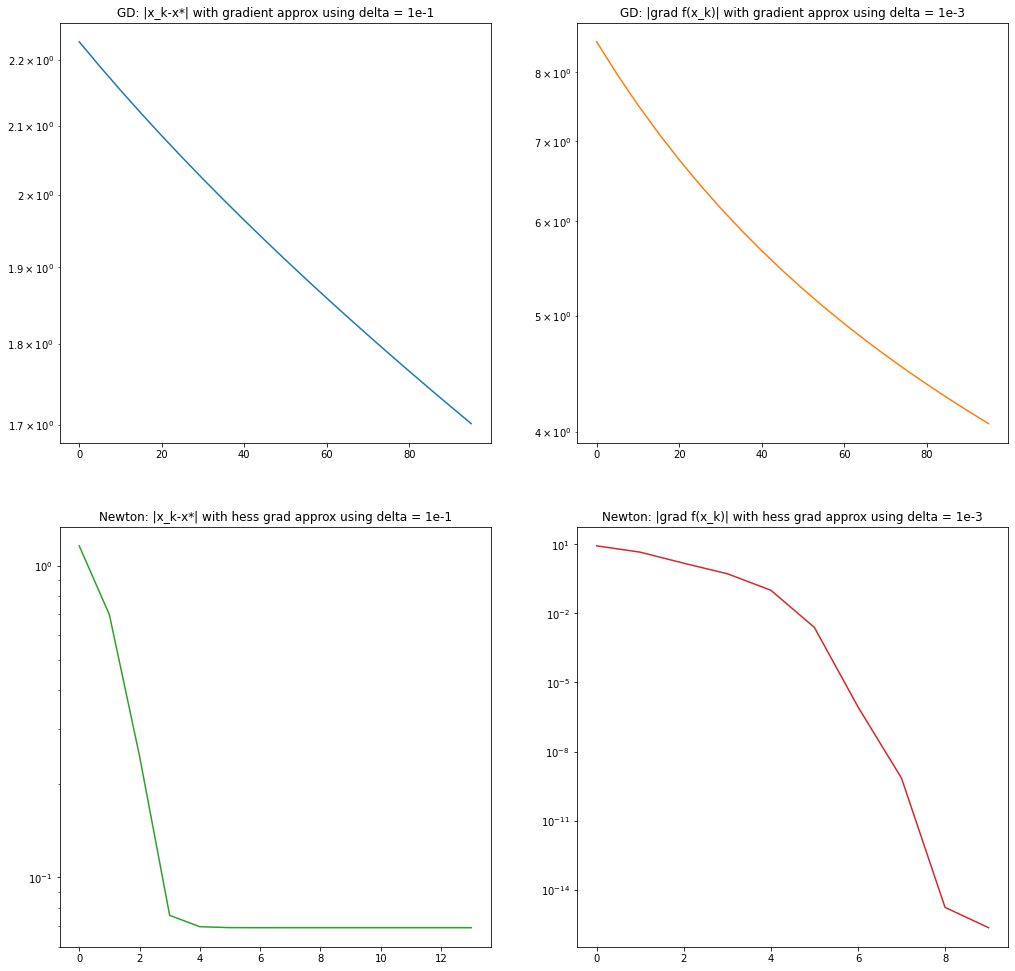

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(iter_gd1, val_x_gd1)
axs[0, 0].set_title('GD: |x_k-x*| with gradient approx using delta = 1e-1')
axs[0, 0].set_yscale('log')
axs[0, 1].plot(iter_gd2, val_grad_gd2, 'tab:orange')
axs[0, 1].set_title('GD: |grad f(x_k)| with gradient approx using delta = 1e-3')
axs[0, 1].set_yscale('log')

axs[1, 0].plot(iter_newton1, val_x_newton1, 'tab:green')
axs[1, 0].set_title('Newton: |x_k-x*| with hess grad approx using delta = 1e-1')
axs[1, 0].set_yscale('log')
axs[1, 1].plot(iter_newton2, val_grad_newton2, 'tab:red')
axs[1, 1].set_title('Newton: |grad f(x_k)| with hess grad approx using delta = 1e-3')
axs[1, 1].set_yscale('log')

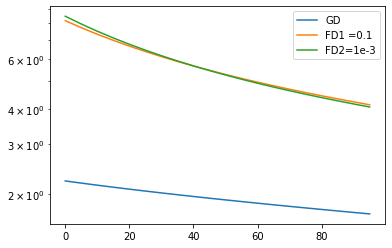

In [51]:
plt.plot(iter_gd, val_x_gd)
plt.plot(iter_gd1, val_grad_gd1)
plt.plot(iter_gd2, val_grad_gd2)
plt.yscale('log')
plt.legend(["GD", "FD1 =0.1",  "FD2=1e-3"]);

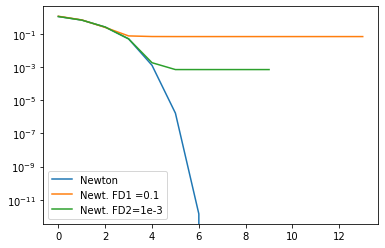

In [52]:
plt.plot(iter_newton, val_x_newton)
plt.plot(iter_newton1, val_x_newton1)
plt.plot(iter_newton2, val_x_newton2)
plt.yscale('log')
plt.legend(["Newton", "Newt. FD1 =0.1",  "Newt. FD2=1e-3"]);